In [1]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, multiply, BatchNormalization, ReLU, Activation
from keras.models import Model
from keras.initializers import RandomNormal

2022-12-07 15:44:04.023196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from datetime import datetime
import os, shutil
import copy
import pickle
import math

from config import Config
import util
from wnet import WNet
from SoftNCutLoss import NCutLoss2D

/Users/sergekeita/opt/anaconda3/envs/Bootcamp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config = Config()
print(config.k)

data_xform_input = transforms.Compose([
    transforms.Resize((config.input_size,config.input_size)),
    transforms.ToTensor(),
    ])

data_xform_target = transforms.Compose([
        transforms.Resize((config.input_size,config.input_size)),
        transforms.PILToTensor(),
    ])
traindataset = torchvision.datasets.VOCSegmentation(
    root="./Data",
    year="2012",
    image_set="train",
    transform=data_xform_input,
    target_transform=data_xform_target,
    download=True)
    
traindataloader = torch.utils.data.DataLoader(traindataset,batch_size=config.batch_size,num_workers=4, shuffle=True)

#dataiter = iter(traindataloader)
#images, labels = dataiter.next()

2
Using downloaded and verified file: ./Data/VOCtrainval_11-May-2012.tar
Extracting ./Data/VOCtrainval_11-May-2012.tar to ./Data


In [4]:
valdataset = torchvision.datasets.VOCSegmentation(
    root="./Data",
    year="2012",
    image_set="val",
    transform=data_xform_input,
    target_transform=data_xform_target,
    download=True)
    
valdataloader = torch.utils.data.DataLoader(valdataset,batch_size=config.val_batch_size,num_workers=4, shuffle=False)

Using downloaded and verified file: ./Data/VOCtrainval_11-May-2012.tar
Extracting ./Data/VOCtrainval_11-May-2012.tar to ./Data


In [5]:

#img, labels = next(iter(traindataloader))


# Model WNET 

In [6]:
autoencoder = WNet()

In [7]:
ncutloss_layer = NCutLoss2D()

In [8]:
if torch.cuda.is_available():
    autoencoder = autoencoder.cuda

optimizerE = torch.optim.Adam(autoencoder.U_encoder.parameters(), lr=0.003)
optimizerW = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [9]:
if config.debug:
    print(autoencoder)

WNet(
  (U_encoder): U_Net(
    (first_module): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.65, inplace=False)
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Dropout(p=0.65, inplace=False)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_modules): ModuleList(
      (0): ConvModule(
        (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        (pointwise): Conv2d(64, 128, kernel_size

### Loss criterion

In [10]:
def reconstruction_loss(x, x_prime):
        reconloss = F.mse_loss(x, x_prime, reduction='sum')
        return reconloss

### Train Loop

In [11]:
autoencoder.train()

WNet(
  (U_encoder): U_Net(
    (first_module): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.65, inplace=False)
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Dropout(p=0.65, inplace=False)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_modules): ModuleList(
      (0): ConvModule(
        (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        (pointwise): Conv2d(64, 128, kernel_size

In [12]:
progress_images, progress_expected = next(iter(valdataloader))

In [13]:
modelName = str(datetime.now())

In [14]:
for epoch in range(20):
    running_loss = 0.0
    ncutloss = []
    reconloss = []
    for i, [inputs, outputs] in enumerate(traindataloader, 0):

        if i == 10:
            break

        if torch.cuda.is_available():
            inputs  = inputs.cuda()
            outputs = outputs.cuda()
        
        optimizerE.zero_grad()

        segmentations = autoencoder.forward_encoder(inputs)
        l_soft_n_cut     = ncutloss_layer (segmentations, inputs)
        l_soft_n_cut.backward(retain_graph=False)
        optimizerE.step()
        ncutloss.append(l_soft_n_cut)

        optimizerW.zero_grad()

        segmentations,  reconstructions = autoencoder.forward(inputs)

        l_reconstruction = reconstruction_loss(
            inputs if config.variationalTranslation == 0 else outputs,
            reconstructions
        )

        reconloss.append(l_reconstruction)

        l_reconstruction.backward(retain_graph=False)  # We only need to do retain graph =true if we're backpropping from multiple heads
        optimizerW.step()

        running_loss += l_reconstruction + l_soft_n_cut #loss.item()

        if config.showSegmentationProgress and i == 0: # If first batch in epoch
            util.save_progress_image(autoencoder, progress_images, progress_expected, epoch)

    
    epoch_loss = running_loss / len(traindataloader.dataset)
    print(f"Epoch {epoch} loss: {epoch_loss:.6f}")

    path = os.path.join("./models/", modelName.replace(":", " ").replace(".", " ").replace(" ", "_"))
    torch.save(autoencoder, path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0 loss: 1841.526245


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1 loss: 926.041260


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2 loss: 670.730286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3 loss: 637.780762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4 loss: 685.929321


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5 loss: 689.553101


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6 loss: 697.796936


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7 loss: 745.744629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8 loss: 673.593933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9 loss: 701.435974


# PostProcessing

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [16]:
segmentations, crftest,reconstructions = autoencoder.forward_enc_crf(progress_images)

In [17]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
attempts=10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


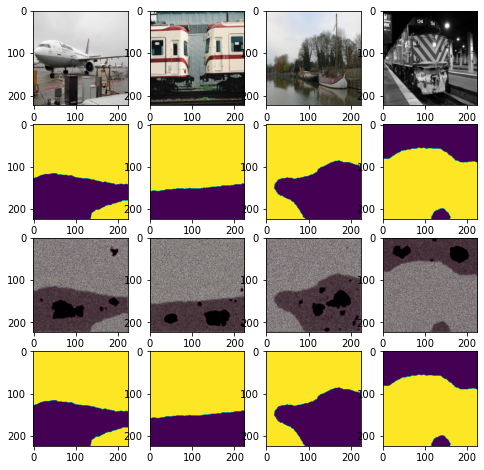

In [18]:

f, axes = plt.subplots(4, config.val_batch_size, figsize=(8,8))
for i in range(config.val_batch_size):
    segmentation = segmentations[i]
    pixels = torch.argmax(segmentation, axis=0).float() / config.k # to [0,1]
    picelcrf = torch.argmax(crftest[i],axis=0).float() / config.k

    axes[0, i].imshow(progress_images[i].permute(1, 2, 0))
    axes[1, i].imshow(pixels.detach().cpu())
    axes[2, i].imshow(reconstructions[i].detach().cpu().permute(1, 2, 0))
    axes[3, i].imshow(picelcrf.detach().cpu())

In [19]:
if torch.cuda.is_available():
    autoencoder2 = torch.load("./models/2022-12-06_14_59_12_861829")
else:
    autoencoder2 = torch.load("./models/2022-12-06_14_59_12_861829", map_location=torch.device('cpu'))
    

In [20]:
def count_predicted_pixels(predicted, actual):
        pixel_count = torch.zeros(config.k, config.k)
        for k in range(config.k):
            mask = (predicted == k)
            masked_actual = actual[mask]
            for i in range(config.k):
                pixel_count[k][i] += torch.sum(masked_actual == i)
        return pixel_count

In [21]:
def convert_prediction(pixel_count, predicted):
        map = torch.argmax(pixel_count, dim=1)
        for x in range(predicted.shape[0]):
            for y in range(predicted.shape[1]):
                predicted[x, y] = map[predicted[x, y].long()]
        return predicted

In [22]:
pixelspred = torch.argmax(segmentations[0], dim=0,keepdim=True).float()
pixelspred.shape,progress_expected[0].shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [23]:
pixelspred.shape,progress_expected[0].shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [24]:
pc = count_predicted_pixels(pixelspred,progress_expected[0])
prediction = convert_prediction(pc, pixelspred)

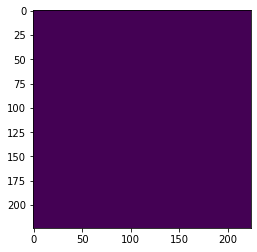

In [25]:
plt.imshow(prediction.permute(1, 2, 0))

In [26]:
from crfseg import CRF